In [1]:
import os 
import pickle
import numpy as np
from os.path import join  

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.distribute import MirroredStrategy, OneDeviceStrategy

for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

datasets = join(os.getcwd(), "datasets")
preprocessed_datasets = join(datasets, "preprocessed")

X_all, y_all, X_test = pickle.load(open(join(preprocessed_datasets, "cleaned_ohe.pickle"), 'rb'))

strategy = MirroredStrategy(["GPU:0", "GPU:1"])
# strategy = OneDeviceStrategy("CPU")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
class BCR(tf.keras.metrics.Metric):
    def __init__(self, name='BCR', dtype=None):
        super().__init__(name, dtype=dtype)
        self.TP = tf.keras.metrics.TruePositives()
        self.TN = tf.keras.metrics.TrueNegatives()
        self.FP = tf.keras.metrics.FalsePositives()
        self.FN = tf.keras.metrics.FalseNegatives()
        
        self.bcr = self.add_weight(name='bcr', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        
        self.TP.update_state(y_true, y_pred)
        self.TN.update_state(y_true, y_pred)
        self.FP.update_state(y_true, y_pred)
        self.FN.update_state(y_true, y_pred)
        
        tp = self.TP.result() 
        tn = self.TN.result()
        fp = self.FP.result()
        fn = self.FN.result()
        
        self.bcr.assign(.5 * ((tp / (tp + fn)) + (tn / (fp + tn))))
    
    def result(self):
        return self.bcr
        
    def reset_states(self):
        self.bcr.assign(0.0)


def recall(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def bcr(y_true, y_pred):
    return .5 * (recall(y_true, y_pred) + specificity(y_true, y_pred))

def p1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    m = m1(y_true, y_pred)
    return tp / (m + K.epsilon())

def p2(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    m = m2(y_true, y_pred)
    return tn / (m + K.epsilon())

def m1(y_true, y_pred):
    return K.sum(K.round(y_true))

def m2(y_true, y_pred):
    return K.sum(K.round(K.clip(1 - y_true, 0, 1)))

def P(bcr, bcr_hat, p1, p2, m1, m2):
    bcr_delta = np.abs(bcr - bcr_hat)
    sigma = .5 * np.sqrt(((1-p1)*p1/m1) + (p2*(1-p2)/m2))
    return bcr - bcr_delta * (1 - np.exp(- bcr_delta / sigma))

def P_model(model, X_train, y_train, X_val, y_val, with_info=False):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    bcr_ = bcr(y_train, y_train_pred)
    bcr_hat = bcr(y_val, y_val_pred)
    
    p1_ = p1(y_val, y_val_pred)
    p2_ = p2(y_val, y_val_pred)
    m1_ = m1(y_val, y_val_pred)
    m2_ = m2(y_val, y_val_pred)
    
    p = P(bcr_, bcr_hat, p1_, p2_, m1_, m2_)
    
    if with_info:
        return p, {'bcr':bcr_, 'bcr_hat':bcr_hat, 'p1':p1_, 'p2':p2_, 'm1':m1_, 'm2':m2_}
    
    return p
    

class BCREarlyStopping(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

      Arguments:
          patience: Number of epochs to wait after min has been hit. After this
          number of no improvement, training stops.
      """

    def __init__(self, patience=0, restore_best_weights=False):
        super(BCREarlyStopping, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = .0
        
    def on_epoch_end(self, epoch, logs=None):
        bcr = logs.get("bcr")
        val_bcr = logs.get("val_bcr")
        p1 = logs.get("val_p1")
        p2 = logs.get("val_p2")
        m1 = logs.get("val_m1")
        m2 = logs.get("val_m2")
        current = P(bcr, val_bcr, p1, p2, m1, m2)
        
        if np.less(self.best, current):
            print(f"New best p value : {current}")
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    print(f"Restoring model weights from the end of the best epoch. Best value : {self.best:.3f}")
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [3]:
def get_model():
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
            tf.keras.layers.Dropout(1/3),
            tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.0), activation='sigmoid')
        ], name='linear_dnn')
        
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            metrics=[bcr, p1, p2, m1, m2, "accuracy", ]
        )
    return model

model = get_model()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_bcr', factor=.5, patience=10, verbose=2),
    BCREarlyStopping(patience=30, restore_best_weights=True)
]

model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "linear_dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 1306756)           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1306757   
Total params: 1,306,757
Trainable params: 1,306,757
Non-trainable params: 0
______________

In [4]:
from utils import KFoldTrainingSequential

results = KFoldTrainingSequential.compute(X_all, y_all, get_model, 1000, 32, k=5, callbacks=callbacks)

========================== Begin fit on fold 1/5 ==========================

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/devic

/home/romaingrx/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


New best p value : 0.40630808675062347
New best p value : 0.463436800283142
New best p value : 0.5202372604904594
New best p value : 0.5769634364642399
New best p value : 0.6110467025105882
New best p value : 0.642508007363133
New best p value : 0.6731807850318049

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
New best p value : 0.6920567418948813
New best p value : 0.7089808656022232

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch. Best value : 0.709
Epoch 00048: early stopping
------------------ Report for Sequential -------------------

P score : 0.798
BCR     : 0.982
BCR hat : 0.793
========================== Begin fit on fold 3/5 ==========================

INFO:tensorflow:Reduce to /job:localhost/repli

/home/romaingrx/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


New best p value : 0.5
New best p value : 0.5264086351168099
New best p value : 0.5268943127185435
New best p value : 0.537891457787854
New best p value : 0.5584375229177253
New best p value : 0.5615437708752169
New best p value : 0.6086758367961569
New best p value : 0.6930642277252138

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
New best p value : 0.7191704715784515

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
New best p value : 0.7216739528980851

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
New best p value : 0.7245728811375682

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch. Best value : 0.725
Epoch 00072: early stopping
---------

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, shuffle=True, train_size=.9)

model = get_model()

fitted = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=1000,
                    callbacks=callbacks,
                   )

Epoch 1/1000
9/9 [==============================] - ETA: 21s - loss: 24.0253 - bcr: 0.5000 - p1: 0.9375 - p2: 0.0625 - m1: 7.0000 - m2: 9.0000 - accuracy: 0.43 - ETA: 0s - loss: 625.9590 - bcr: 0.5000 - p1: 0.7031 - p2: 0.2969 - m1: 6.7500 - m2: 9.2500 - accuracy: 0.48 - ETA: 0s - loss: 1071.9993 - bcr: 0.5000 - p1: 0.5729 - p2: 0.4271 - m1: 6.7778 - m2: 9.2222 - accuracy: 0.500 - ETA: 0s - loss: 1302.1596 - bcr: 0.5000 - p1: 0.4883 - p2: 0.5117 - m1: 6.7396 - m2: 9.2604 - accuracy: 0.513 - ETA: 0s - loss: 1387.7671 - bcr: 0.5000 - p1: 0.4281 - p2: 0.5719 - m1: 6.6517 - m2: 9.3483 - accuracy: 0.527 - ETA: 0s - loss: 1419.0967 - bcr: 0.5000 - p1: 0.4106 - p2: 0.5894 - m1: 6.6264 - m2: 9.3736 - accuracy: 0.533 - ETA: 0s - loss: 1451.7526 - bcr: 0.5000 - p1: 0.4119 - p2: 0.5881 - m1: 6.5471 - m2: 9.4529 - accuracy: 0.530 - ETA: 0s - loss: 1464.9200 - bcr: 0.5000 - p1: 0.4219 - p2: 0.5781 - m1: 6.4709 - m2: 9.5291 - accuracy: 0.525 - ETA: 0s - loss: 1465.5921 - bcr: 0.4999 - p1: 0.4247 - p

/home/romaingrx/anaconda3/envs/rapidsai/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


New best p value : 0.49814820289611816
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 770.8324 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 5.5000 - m2: 10.5000 - accuracy: 0.656 - ETA: 0s - loss: 881.4999 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 5.8750 - m2: 10.1250 - accuracy: 0.632 - ETA: 0s - loss: 889.2483 - bcr: 0.5000 - p1: 0.0000e+00 - p2: 1.0000 - m1: 6.0278 - m2: 9.9722 - accuracy: 0.623 - ETA: 0s - loss: 861.2428 - bcr: 0.5035 - p1: 0.0104 - p2: 0.9965 - m1: 6.1146 - m2: 9.8854 - accuracy: 0.6198   - ETA: 0s - loss: 819.9032 - bcr: 0.5075 - p1: 0.0550 - p2: 0.9600 - m1: 6.2117 - m2: 9.7883 - accuracy: 0.61 - ETA: 0s - loss: 791.7775 - bcr: 0.5095 - p1: 0.1060 - p2: 0.9130 - m1: 6.2319 - m2: 9.7681 - accuracy: 0.60 - ETA: 0s - loss: 763.0825 - bcr: 0.5128 - p1: 0.1555 - p2: 0.8701 - m1: 6.2294 - m2: 9.7706 - accuracy: 0.59 - ETA: 0s - loss: 736.8197 - bcr: 0.5157 - p1: 0.1881 - p2: 0.8432 - m1: 6.1929 - m2: 9.8071 - accuracy: 0.59 - ETA: 0s 

<ipython-input-5-174dcbfcd16c>:17: UserWarning: Legend does not support 'ss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  _ = plt.legend(["ss"]*4, [p1, p2, p3, p4])


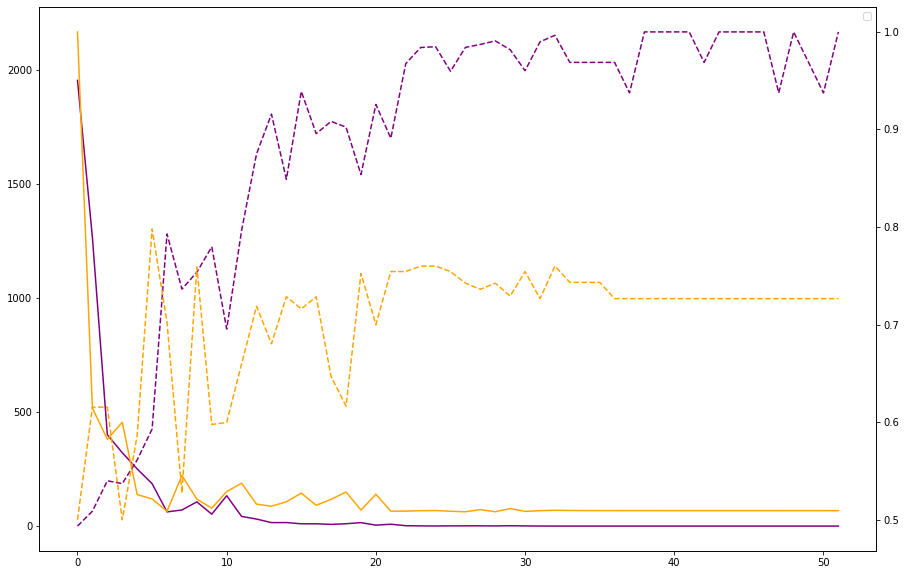

In [5]:
import matplotlib.pyplot as plt

history = fitted.history
epochs_ = np.arange(len(history['loss']))

fig = plt.figure(figsize=(15, 10))
plt.title("")
axL = plt.gca()
axR = axL.twinx()

p1 = axL.plot(epochs_, history['loss'], label='loss', color='purple', ls='-')
p2 = axL.plot(epochs_, history['val_loss'], label='val_loss', color='orange', ls='-')

p3 = axR.plot(epochs_, history['bcr'], label='bcr', color='purple', ls='--')
p4 = axR.plot(epochs_, history['val_bcr'], label='val_bcr', color='orange', ls='--')

_ = plt.legend(["ss"]*4, [p1, p2, p3, p4])

Get the performance of the model
---

In [17]:
from utils import Report

report = Report(model, X_train, y_train, X_val, y_val).to_stdout()

------------------ Report for Sequential -------------------

P score : 0.820
BCR     : 1.000
BCR hat : 0.805


Save the csv output and model
---

In [15]:
y_test = model.predict(X_test).round().astype(np.uint8).flatten()

report.to_contest_csv(f"dnn_linear_{report.p.numpy():.3f}", y_test, save_model=True)